In [12]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import argparse
import cv2
from torch.autograd import Function
from torchvision import models
import torch.backends.cudnn as cudnn
from tensorboardX import SummaryWriter







In [13]:
torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("GPU available")
    device = "cuda:0"
else:
    print("CPU available")
    device = "cpu"
    
device = torch.device(device)
print(device)


CPU available
cpu


In [14]:
#data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
data_dir = os.path.join( "/Users","amoghraut","Downloads","cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print("train patch size:", len(train_fns))
print("validation patch size:", len(val_fns))

train patch size: 2975
validation patch size: 500


sample image shape:  (256, 512, 3)
image shape: (256, 256, 3)
label shape: (256, 256, 3)


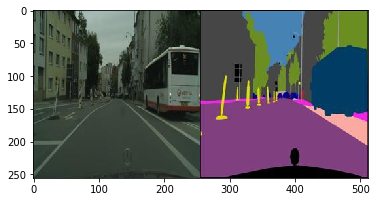

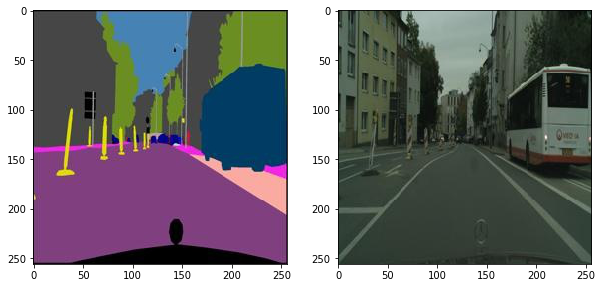

In [15]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)

def split_image(image):
    image = np.array(image)
    cityscape = image[:, :256, :] 
    label = image[:, 256:, :]
    return cityscape, label

sample_image = np.array(sample_image)
print("sample image shape: ",sample_image.shape)

cityscape, label = split_image(sample_image)
print("image shape:" , cityscape.shape)
print("label shape:" , label.shape)

cityscape = Image.fromarray(cityscape) 
label = Image.fromarray(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].imshow(cityscape)
axes[0].imshow(label)

[[216 248 155]
 [ 30 125 126]
 [ 56  77  44]
 ...
 [160  92 134]
 [176 254  41]
 [236 252 102]]
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 9 8]
 ...
 [8 4 4 ... 4 4 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]]


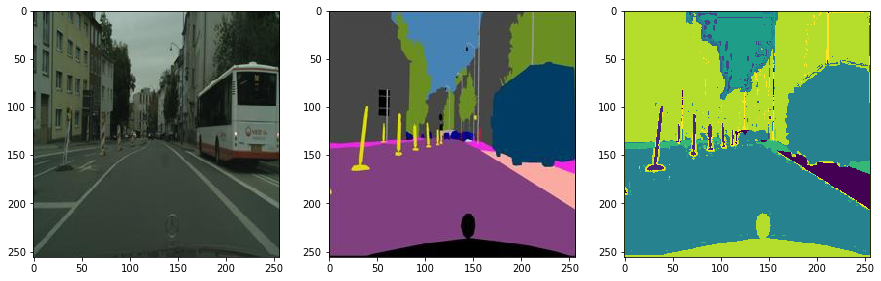

In [28]:
num_items = 1000  
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)

num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

label_model.predict(color_array[:5, :])

cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)


In [17]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [18]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.down_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.up_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        down_11_out = self.down_11(X) 
        down_12_out = self.down_12(down_11_out) 
        down_21_out = self.down_21(down_12_out) 
        down_22_out = self.down_22(down_21_out) 
        down_31_out = self.down_31(down_22_out) 
        down_32_out = self.down_32(down_31_out) 
        down_41_out = self.down_41(down_32_out) 
        down_42_out = self.down_42(down_41_out) 
        middle_out = self.middle(down_42_out) 
        up_11_out = self.up_11(middle_out) 
        up_12_out = self.up_12(torch.cat((up_11_out, down_41_out), dim=1))
        up_21_out = self.up_21(up_12_out) 
        up_22_out = self.up_22(torch.cat((up_21_out, down_31_out), dim=1))
        up_31_out = self.up_31(up_22_out) 
        up_32_out = self.up_32(torch.cat((up_31_out, down_21_out), dim=1))
        up_41_out = self.up_41(up_32_out) 
        up_42_out = self.up_42(torch.cat((up_41_out, down_11_out), dim=1)) 
        output_out = self.output(up_42_out) 
        return output_out

In [19]:
batch_size = 16
epochs = 20
lr = 0.01

In [20]:
torch.cuda.empty_cache()

In [21]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

model = UNet(num_classes=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

UNet(
  (down_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_31): Sequential(
    (0): Co

In [13]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [19]:
torch.save(model.state_dict(),'unet.pth' )

In [39]:
model.load_state_dict(torch.load('unet.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [41]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


0.9628801414644531


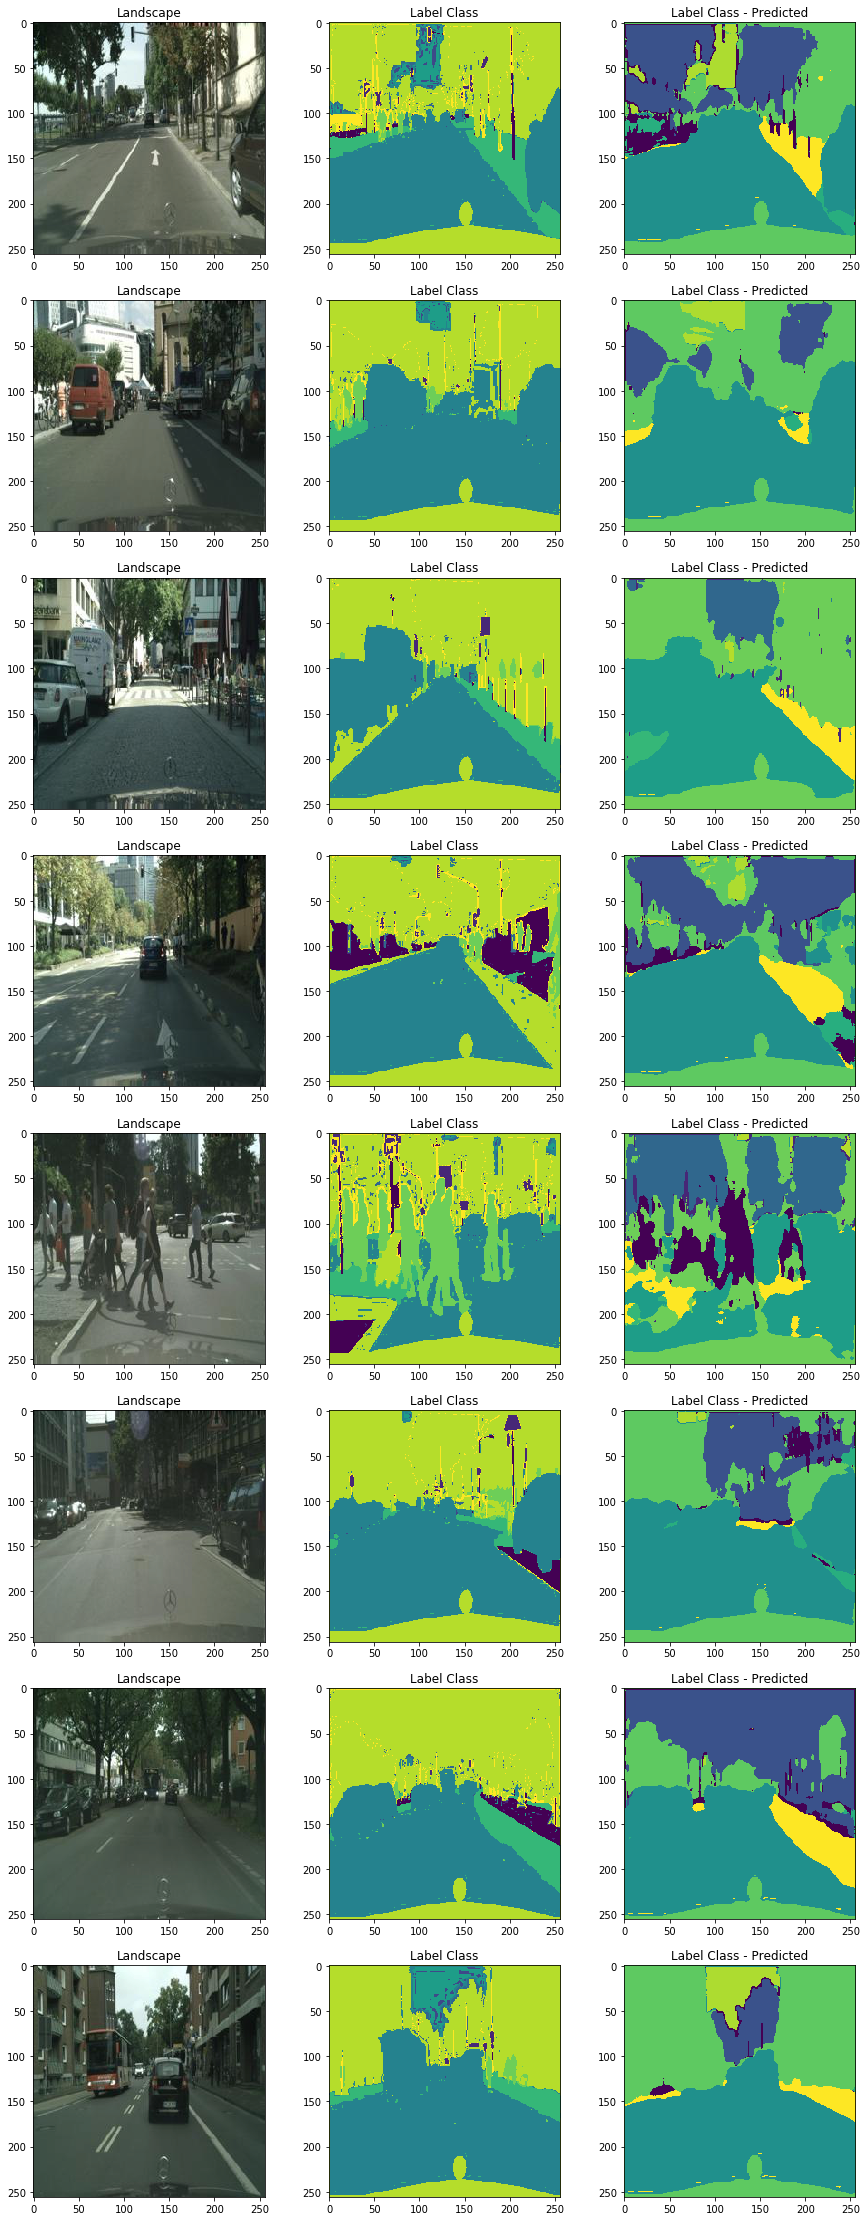

In [46]:

fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

print(sum(iou_scores) / len(iou_scores))